<a href="https://colab.research.google.com/github/jasonbuchanan145/Data-Modeling/blob/main/Copy_of_hugging_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

!pip install datasets
!pip install huggingface_hub
!pip install py-solc-x
!pip install -U bitsandbytes
!pip install slither-analyzer
!solc-select install 0.8.28
!pip install trl
!pip install tensorboard
!solc-select use 0.8.28

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Installing solc '0.8.28'...
Version '0.8.28' installed.
Switched global version to 0.8.28


In [ ]:
from google.colab import files

# Create a working directory for our Solidity project
!mkdir -p solidity_project
%cd solidity_project

# Initialize npm project and install dependencies
!npm init -y
!npm install --save-dev hardhat @nomicfoundation/hardhat-toolbox @openzeppelin/contracts
!npm install @chainlink/contracts # Add other common dependencies as needed


# Create contracts directory
!mkdir -p contracts

/content/solidity_project
Wrote to /content/solidity_project/package.json:

{
  "name": "solidity_project",
  "version": "1.0.0",
  "main": "index.js",
  "scripts": {
    "test": "echo \"Error: no test specified\" && exit 1"
  },
  "keywords": [],
  "author": "",
  "license": "ISC",
  "devDependencies": {
    "@chainlink/contracts": "^1.3.0",
    "@nomicfoundation/hardhat-toolbox": "^5.0.0",
    "@openzeppelin/contracts": "^5.3.0",
    "hardhat": "^2.23.0"
  },
  "dependencies": {
    "abbrev": "^1.0.9",
    "acorn": "^8.14.1",
    "acorn-walk": "^8.3.4",
    "adm-zip": "^0.4.16",
    "aes-js": "^4.0.0-beta.5",
    "agent-base": "^6.0.2",
    "aggregate-error": "^3.1.0",
    "ajv": "^8.17.1",
    "amdefine": "^1.0.1",
    "ansi-align": "^3.0.1",
    "ansi-colors": "^4.1.3",
    "ansi-escapes": "^4.3.2",
    "ansi-regex": "^5.0.1",
    "ansi-styles": "^4.3.0",
    "antlr4ts": "^0.5.0-alpha.4",
    "anymatch": "^3.1.3",
    "arg": "^4.1.3",
    "argparse": "^2.0.1",
    "array-back": "^3

In [ ]:
import logging
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)
global file_handler
# Create a file handler and set the filename
file_handler = logging.FileHandler('/content/log_epoch.log')

# Create a formatter and add it to the handler
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add the handler to the logger
log.addHandler(file_handler)
log.propagate = False

In [ ]:
# Standard libraries
import os
import re
import json
import tempfile
import shutil
import glob
import subprocess
import requests
import matplotlib.pyplot as plt
import hashlib
from pathlib import Path

# PyTorch and related
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.amp import autocast
from torch.amp import GradScaler
from datasets import load_dataset, Dataset as HFDataset # Import HFDataset from datasets
# Transformers and TRL
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TFAutoModelForMaskedLM,
    GenerationConfig,
    pipeline,
    BitsAndBytesConfig
)
from trl import (
    PPOTrainer,
    PPOConfig,
    AutoModelForCausalLMWithValueHead,
    create_reference_model
)

# Datasets
from datasets import load_dataset

# Solidity Compiler
from solcx import compile_standard, install_solc

# BitsAndBytes
from bitsandbytes.optim import Adam8bit

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# Set the path to save the best model
output_dir = "/content/drive/MyDrive/llama_generated_contracts/explanations"

In [ ]:
import os
import glob
def find_latest_checkpoint(checkpoint_dir: str) -> str | None:
    """
    Scan `checkpoint_dir` for checkpoint files matching 'checkpoint_epoch_*_prompt_*.pt'
    and return the path to the most recently created one. Returns None if none found.
    """
    pattern = os.path.join(checkpoint_dir, "checkpoint_epoch_*_prompt_*.pt")
    candidate_ckpts = glob.glob(pattern)
    if not candidate_ckpts:
        return None
    latest_ckpt = max(candidate_ckpts, key=os.path.getctime)
    return latest_ckpt

def find_latest_hf_model_dir(checkpoint_dir: str) -> str | None:
    """
    Scan `checkpoint_dir` for subdirectories matching 'model_epoch_*_prompt_*'
    and return the path to the most recently created one.

    Returns None if no such directory exists.
    """
    pattern = os.path.join(checkpoint_dir, "model_epoch_*_prompt_*")
    candidate_dirs = glob.glob(pattern)
    if not candidate_dirs:
        return None

    # Choose the dir with the latest creation time
    latest_dir = max(candidate_dirs, key=lambda d: os.path.getctime(d))
    return latest_dir

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
model_name = "Qwen/Qwen2.5-Coder-7B-instruct"
quantization_config = BitsAndBytesConfig(load_in_8bit=True)
ckpt_file = find_latest_checkpoint("/content/drive/MyDrive/checkpoints")
hf_model_dir = find_latest_hf_model_dir("/content/drive/MyDrive/checkpoints")
loaded_checkpoint = False
if hf_model_dir:
   # 1) locate your latest .pt checkpoint with both LM+v_head
    ckpt = torch.load(ckpt_file, map_location="cpu")

    # 2) build fresh model+v_head from the hub (or your cache)
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        "Qwen/Qwen2.5-Coder-7B-instruct",
        device_map="auto",
        quantization_config=quantization_config,
    )

    # 3) overwrite with your previously trained weights
    model.load_state_dict(ckpt["model_state_dict"], strict=False)

    tokenizer = AutoTokenizer.from_pretrained(model_name)


    loaded_checkpoint = True
else:
    # First‑time run: fetch from HF hub
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        model_name,
        device_map="auto",
        quantization_config=quantization_config
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Create a new model instance on CPU
with torch.device("cpu"):
    reference_model = AutoModelForCausalLMWithValueHead.from_pretrained(
        model_name,
        device_map="cpu"
      )

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
def make_prompts(file_path):
  dataset = []
  with open(file_path, 'r') as file:
      for line in file:
          line = line.strip()
          if line.startswith('"') and line.endswith('"'):
              # Remove the surrounding quotes
              clean_line = line[1:-1]
              clean_line = "Using Solidity and having your code start with \"// Begin Smart Contract\" and ending with \"//End Smart Contract\" as comments "+clean_line
              dataset.append(clean_line)
  return dataset
prompts = make_prompts("/content/drive/MyDrive/prompts.txt")
validation_prompts = make_prompts("/content/drive/MyDrive/validation_prompts.txt")

In [ ]:
class AdaptiveKLController:
    """
    Exponential‑moving‑average controller like the one used in Anthropic's and
    OpenAI’s reference PPO code.  Handles both coefficient tuning and hard aborts.
    """
    def __init__(self,
                 initial_kl_coef: float = 0.1,
                 target_kl: float = 0.25,
                 horizon: int = 1000,          # how many updates to reach target
                 hard_cap: float = 1.2):       # kill‑switch ceiling
        self.kl_coef   = initial_kl_coef
        self.target_kl = target_kl
        self.horizon   = horizon
        self.hard_cap  = hard_cap
        self.update_steps = 0

    def update(self, measured_kl: float):
        """
        Called **once per PPO `step`** (not per window) with the batch KL.
        """
        # Hard safety check ---------------------------------------------------
        if measured_kl > self.hard_cap:
            return "explode"        # signal caller to roll back / skip batch

        # Smooth coefficient update ------------------------------------------
        diff = measured_kl - self.target_kl         # + if too high, – if low
        mult = 1 + diff / (self.target_kl * 1.5)    # dampened gain
        mult = max(0.1, min(10.0, mult))            # clamp update factor
        self.kl_coef *= mult ** (1 / self.horizon)  # very small per‑step change
        self.update_steps += 1
        return "ok"


def setup_hardhat_environment():
    """
    Set up the initial Hardhat environment with common dependencies.
    Run this once at the beginning of your notebook.
    """
    import subprocess
    import os

    # Create directories relative to the project root
    os.makedirs('./contracts', exist_ok=True)
    os.makedirs('./artifacts', exist_ok=True)

    log.info("Installing common Solidity dependencies...")
    dependencies = [
        "hardhat",
        "@nomicfoundation/hardhat-toolbox",
        "@openzeppelin/contracts",
        "@chainlink/contracts"
    ]

    install_cmd = ["npm", "install", "--save-dev"] + dependencies
    process = subprocess.run(install_cmd, capture_output=True, text=True)

    if process.returncode != 0:
        log.info(f"Error installing dependencies: {process.stderr}")
        return False

    # Create hardhat.config.js with relative paths for sources and artifacts
    hardhat_config = '''
module.exports = {
  solidity: {
    version: "0.8.20",
    settings: {
      optimizer: {
        enabled: true,
        runs: 200
      },
      evmVersion: "paris"
    }
  },
  paths: {
    sources: "./contracts",
    artifacts: "./artifacts"
  },
  networks: {
    hardhat: {
      chainId: 1337
    }
  },
  mocha: {
    timeout: 40000
  }
};
'''

    with open('hardhat.config.js', 'w') as f:
        f.write(hardhat_config)

    log.info("Hardhat environment setup complete")
    return True

setup_hardhat_environment()
def evaluate_contract_hard(contract_source, full_response):
    """
    Evaluate a Solidity contract by resolving additional dependencies,
    compiling it with Hardhat, and validating the generated artifact.

    Returns:
        dict: {
            "reward": int (10 for success, negative for errors),
            "error_token_indices": list of token indices corresponding to problematic error snippets
        }
    """
    try:
        # Write the contract source to a file in the contracts directory
        contract_path = Path('./contracts/MainContract.sol')
        with open(contract_path, 'w') as f:
            f.write(contract_source)

        # Detect contract name
        contract_name_match = re.search(r'contract\s+(\w+)(?:\s+is\s+[^{]+)?\s*{', contract_source)
        if contract_name_match:
            contract_name = contract_name_match.group(1)
            log.info(f"Detected contract name: {contract_name}")
        else:
            contract_name = "MainContract"
            log.info(f"Could not detect contract name, using default: {contract_name}")

        # Detect import statements that may require additional npm packages
        import_pattern = re.compile(r'import\s+(?:{[^}]*}\s+from\s+)?[\'"](.+?)[\'"];')
        imports = import_pattern.findall(contract_source)

        # Map import prefixes to their corresponding npm package names
        dependency_map = {
            '@openzeppelin/': '@openzeppelin/contracts',
            '@chainlink/': '@chainlink/contracts',
            '@uniswap/': '@uniswap/v3-core',
            'hardhat/': '@nomicfoundation/hardhat-toolbox',
            '@aave/': '@aave/protocol-v2',
            '@compound-finance/': '@compound-finance/contracts',
            '@balancer-labs/': '@balancer-labs/v2-solidity-utils',
            '@1inch/': '@1inch/solidity-utils',
            '@sushiswap/': '@sushiswap/core'
        }

        dependencies_to_install = set()
        for imp in imports:
            for prefix, package in dependency_map.items():
                if prefix in imp:
                    dependencies_to_install.add(package)

        if dependencies_to_install:
            log.info(f"Installing additional dependencies: {', '.join(dependencies_to_install)}")
            install_cmd = ['npm', 'install', '--save-dev'] + list(dependencies_to_install)
            install_process = subprocess.run(install_cmd, capture_output=True, text=True)
            if install_process.returncode != 0:
                log.info(f"Warning: Failed to install some dependencies: {install_process.stderr}")

        # Clean the environment and compile the contract
        subprocess.run(['npx', 'hardhat', 'clean'], capture_output=True)
        compile_process = subprocess.run(
            ['npx', 'hardhat', 'compile', '--force'],
            capture_output=True,
            text=True
        )

        # If compilation fails, extract error token indices
        if compile_process.returncode != 0:
            log.info("Compilation failed")
            log.info(f"STDOUT: {compile_process.stdout}")
            log.info(f"STDERR: {compile_process.stderr}")

            # Extract error snippets using regex matching lines starting with a number then "|"
            stderr = compile_process.stderr
            pattern = r'^\s*\d+\s*\|\s*(.+)$'
            error_snippets = re.findall(pattern, stderr, re.MULTILINE)
            log.info(f"Extracted error snippets: {error_snippets}")
            error_token_indices = []
            # Use offset mapping for precise mapping.
            encoded = tokenizer(full_response, return_offsets_mapping=True)
            offsets = encoded.get('offset_mapping', None)
            if offsets and isinstance(offsets[0], int):
                # This is a single list of integers; wrap it.
                offsets = [tuple(offsets)]
            elif offsets and isinstance(offsets[0], (list, tuple)) and isinstance(offsets[0][0], int):
                # Offsets are already in the correct format; do nothing.
                pass
            else:
              log.info("Offset mapping not available or in unexpected format: %s. Falling back to cumulative-length mapping.", repr(offsets))
              # Fallback: create offsets by cumulative token lengths.
              tokens = tokenizer(full_response, return_tensors="pt").input_ids[0]
              decoded_tokens = tokenizer.batch_decode(tokens, skip_special_tokens=True)
              offsets = []
              current_pos = 0
              for token in decoded_tokens:
                  token_len = len(token)
                  offsets.append((current_pos, current_pos + token_len))
                  current_pos += token_len
            # For each error snippet, find its character span and then map to token indices.
            for snippet in error_snippets:
                snippet_start = full_response.find(snippet)
                if snippet_start != -1:
                    snippet_end = snippet_start + len(snippet)
                    for i, (token_start, token_end) in enumerate(offsets):
                        if token_end > snippet_start and token_start < snippet_end:
                            error_token_indices.append(i)

            error_token_indices = sorted(set(error_token_indices))
            error_count = len(error_snippets)
            # Scale the reward by the number of errors (e.g. -10 per error)
            return {"reward": -1, "error_token_indices": error_token_indices, "error_count": error_count}

        # Verify that the artifact was created
        artifact_dir = Path('artifacts/contracts/MainContract.sol')
        artifact_files = list(artifact_dir.glob('*.json'))
        if not artifact_files:
            log.info("Compilation appeared successful but no artifacts were generated")
            return {"reward": 0, "error_token_indices": [], "error_count": 0}

        log.info("Contract compiled successfully")
        return {"reward": 0.01, "error_token_indices": [], "error_count": 0}

    except Exception as e:
        log.info(f"Error during contract evaluation: {str(e)}")
        return {"reward": -2, "error_token_indices": [], "error_count": 1}

    finally:
        import shutil
        contract_path = Path('contracts/MainContract.sol')
        if contract_path.exists():
            os.remove(contract_path)
        artifacts_path = Path('artifacts/contracts/MainContract.sol')
        if artifacts_path.exists():
            shutil.rmtree(artifacts_path)



def evaluate_contract(contract_source):
    return evaluate_contract_hard(contract_source)

In [ ]:
model.generation_config = GenerationConfig.from_model_config(model.config)

train_dataset = HFDataset.from_dict({"query": prompts})


formatted_prompts = [{"prompt": prompt} for prompt in prompts]
train_dataset = HFDataset.from_list(formatted_prompts)

ppo_config = PPOConfig(
    learning_rate=1e-5,
    batch_size=1,
    mini_batch_size=1,
    num_ppo_epochs=5,
    gamma=1.0,
    lam=0.95,
    cliprange=0.3,
    cliprange_value=0.3,
    vf_coef=0.1,
    seed=42,
    output_dir=output_dir
)

class RunningMeanStd:
    def __init__(self, eps: float = 1e-6):
        self.mean  = 0.0
        self.var   = 1.0
        self.count = eps

    @torch.no_grad()
    def update(self, x: torch.Tensor | float | list[float]):
        x   = torch.as_tensor(x, dtype=torch.float32).flatten()
        n   = x.numel()
        new_count = self.count + n

        new_mean = (self.mean * self.count + x.sum()) / new_count
        new_var  = (
            (self.var * self.count + ((x - new_mean) ** 2).sum()) / new_count
        )

        self.mean, self.var, self.count = new_mean, new_var, new_count

    @torch.no_grad()
    def normalize(self, x):
        x = torch.as_tensor(x, dtype=torch.float32)
        std = (self.var + 1e-8) ** 0.5
        return (x - self.mean) / std


# --- training_safety.py (or inline) ---------------------------------
def is_stable(batch_kl, batch_loss, kl_thr=1.1, loss_thr=1.1):
    return batch_kl < kl_thr and batch_loss < loss_thr


class CustomPPOTrainer(PPOTrainer):
    def __init__(self, *args, **kwargs):
        # Initialize without calling parent init as before
        from transformers import TrainingArguments
        self.args = kwargs.pop('args', None) or TrainingArguments("./output")
        self.policy_model = kwargs.pop('model')
        self.ref_model = kwargs.pop('ref_model')
        self.train_dataset = kwargs.pop('train_dataset')
        self.processing_class = kwargs.pop('processing_class')
        self.setup_data_loader()
        # Initialize the GradScaler for mixed precision training
        self.scaler = GradScaler()
        self.setup_optimizers()
        self.rms = RunningMeanStd()
        self.kl_ctl = AdaptiveKLController(
            initial_kl_coef = 0.1,
            target_kl       = 0.25,
            horizon         = 1000,
            hard_cap        = 1.5
        )

    def setup_data_loader(self):
        from torch.utils.data import DataLoader
        self.dataloader = DataLoader(
            self.train_dataset,
            batch_size=self.args.batch_size,
            shuffle=True
        )

    def setup_optimizers(self):
        # Instead of torch.optim.Adam, use the 8-bit Adam optimizer from bitsandbytes
        self.optimizer = Adam8bit(
            self.policy_model.parameters(),
            lr=self.args.learning_rate
        )


    def step(self, prompts, responses, rewards):
        # Forward / loss ---------------------------------------------------------
        with torch.amp.autocast("cuda", enabled=False):
            loss_dict = self.compute_loss(prompts, responses, rewards)

        kl_here = loss_dict["kl_div"].item()
        verdict  = self.kl_ctl.update(kl_here)

        # -------- 1. safety abort ----------------------------------------------
        if verdict == "explode":
            # no optimizer step, no grad accumulation
            self.optimizer.zero_grad(set_to_none=True)
            log.warning(f"KL {kl_here:.3f} > hard cap {self.kl_ctl.hard_cap}. "
                            "Batch skipped.")
            return {k: (v.item() if torch.is_tensor(v) else v)
                    for k, v in loss_dict.items()}

        # -------- 2. normal update ---------------------------------------------
        loss = loss_dict["total_loss"]          # already includes adaptive KL term
        self.optimizer.zero_grad(set_to_none=True)   # clear old grads
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 1.0)

        # bits‑and‑bytes fp‑dtype quirks
        for group in self.optimizer.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad = p.grad.to(p.dtype)

        self.optimizer.step()

        # -------- 3. bookkeeping -----------------------------------------------
        return {
            "total_loss":  loss.item(),
            "loss_policy": loss_dict["loss_policy"].item(),
            "loss_value":  (loss_dict["loss_value"]
                            if isinstance(loss_dict["loss_value"], float)
                            else loss_dict["loss_value"].item()),
            "kl_div":      kl_here,
            "kl_coef":     self.kl_ctl.kl_coef     # handy for logs
        }


    def compute_loss(self, prompt_ids, response_ids, rewards):
        pad_id = self.processing_class.pad_token_id
        attention_mask = (response_ids != pad_id).to(response_ids.device, dtype=torch.long)

        outputs = self.policy_model(
            input_ids=response_ids,
            attention_mask=attention_mask,
            use_cache=False,
            return_dict=True
        )
        if isinstance(outputs, dict):
            logits = outputs["logits"]
            value_predictions = outputs.get("value", None)
        else:
            logits = outputs[0]
            value_predictions = outputs[1] if len(outputs) > 1 else None

        new_policy_log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        new_log_probs = new_policy_log_probs.gather(
            dim=-1, index=response_ids.unsqueeze(-1)
        ).squeeze(-1)

        with torch.no_grad():
            cpu_response_ids = response_ids.to("cpu")
            cpu_attention_mask = attention_mask.to("cpu")
            ref_outputs = self.ref_model(
                input_ids=cpu_response_ids,
                attention_mask=cpu_attention_mask,
                use_cache=False,
                return_dict=True
            )
            if isinstance(ref_outputs, dict):
                ref_logits = ref_outputs["logits"]
            else:
                ref_logits = ref_outputs[0]
        ref_logits = ref_logits.to(response_ids.device)
        old_policy_log_probs = torch.nn.functional.log_softmax(ref_logits, dim=-1)
        old_log_probs = old_policy_log_probs.gather(
            dim=-1, index=response_ids.unsqueeze(-1)
        ).squeeze(-1)

        ratios = torch.exp(new_log_probs - old_log_probs)
        rewards_tensor = torch.as_tensor(rewards, dtype=torch.float32,
                                        device=ratios.device)

        if rewards_tensor.dim() == 0:                 # pure scalar
            # make a (1 × 1) then expand
            advantage = rewards_tensor.view(1, 1).expand_as(ratios)
        elif rewards_tensor.dim() == 1:               # length = seq_len
            # make a (1 × L) row – matches ratios
            advantage = rewards_tensor.unsqueeze(0).expand_as(ratios)
        else:                                         # already 2‑D
            advantage = rewards_tensor.expand_as(ratios)
        clip_epsilon = 0.2
        clipped_ratios = torch.clamp(ratios, 1 - clip_epsilon, 1 + clip_epsilon)
        surrogate_loss = torch.min(ratios * advantage, clipped_ratios * advantage)
        loss_policy = -torch.mean(surrogate_loss)

        if value_predictions is not None:
            loss_value = torch.nn.functional.mse_loss(value_predictions.squeeze(-1), rewards_tensor)
        else:
            loss_value = 0.0

        kl_div = torch.nn.functional.kl_div(
            new_policy_log_probs, old_policy_log_probs.exp(), reduction='batchmean'
        )
        kl_coef = self.kl_ctl.kl_coef
        total_loss = loss_policy + loss_value + kl_coef * kl_div

        log.info(f"compute_loss: loss_policy={loss_policy.item():.4f}, "
                 f"loss_value={loss_value if isinstance(loss_value, float) else loss_value.item():.4f}, "
                 f"kl_div={kl_div.item():.4f}, total_loss={total_loss.item():.4f}")
        return {"total_loss": total_loss, "loss_policy": loss_policy, "loss_value": loss_value, "kl_div": kl_div}

# Use the custom trainer if needed
ppo_trainer = CustomPPOTrainer(
    args=ppo_config,
    model=model,
    ref_model=reference_model,
    reward_model=evaluate_contract,
    train_dataset=train_dataset,
    processing_class=tokenizer
)

In [ ]:
def generate_text(prompt, max_new_tokens=2000, temperature=0.7):
    """Generate text using the official Qwen pattern"""
    # Format messages properly
    messages = [
            {"role": "system", "content": "You are an expert Solidity developer specialized in writing secure, efficient smart contracts. "+
            "These contracts are intended to test your capabilities so ensure that you always provide complete, working code that compiles with no placeholders. "
            "If there are values that you don't know, for example what to set an integer value to, just set it to any number. If there is a workflow that is ambiguous make reasonable assumptions. If you need a wallet id to accompilsh a task use 0x1234567890AbcdEF1234567890aBcdef12345678"},
            {"role": "user", "content": prompt}
        ]
    # Apply chat template as shown in quickstart
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Create inputs
    model_inputs = tokenizer([text], return_tensors="pt").to("cuda:0")

    # Generate with proper settings
    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            top_p=0.95,
            repetition_penalty=1.1
        )

    # Extract only the new tokens
    generated_ids = [
        output_ids[len(input_ids):]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode only the response portion
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return response

In [ ]:
def extract_contract_code(response_text):
    """Extract the contract code from model response with improved pattern matching.
    Priority order:
    1. Find the last code block (```solidity ... ```)
    2. Look for Begin/End Smart Contract markers
    """
    # Case 1: Look for the LAST code block with solidity language marker
    code_blocks = code_blocks = re.findall(r"```solidity\s*(.*?)```", response_text, re.DOTALL)
    if code_blocks:
        # Get the last code block (highest priority)
        return code_blocks[-1]


    # Case 2: Look for markers outside or inside code blocks - use LAST occurrence
    start_marker = "// Begin Smart Contract"
    end_marker = "// End Smart Contract"

    # Find the LAST occurrence of the start marker
    start_idx = response_text.rfind(start_marker)

    # Find the LAST occurrence of the end marker
    end_idx = response_text.rfind(end_marker)

    if start_idx != -1 and end_idx != -1 and start_idx < end_idx:
        # Check if there's a closing bracket on the next line after the end marker
        end_marker_pos = end_idx + len(end_marker)
        next_closing_bracket = response_text[end_marker_pos:].find("}")

        if next_closing_bracket != -1 and response_text[end_marker_pos:end_marker_pos+next_closing_bracket].strip() == "":
            # Include the closing bracket if it's on the next line
            return response_text[start_idx:end_marker_pos + next_closing_bracket + 1]
        else:
            return response_text[start_idx:end_marker_pos]

    # Case 3 look for just tripple backticks (happens if the LLM writes a smart contract in javascript and ignores instructions or starts to degrade)
    code_blocks = code_blocks = re.findall(r"```\s*(.*?)```", response_text, re.DOTALL)
    if code_blocks:
        return code_blocks[-1]

    # Case 4: No markers and no code blocks
    log.info("No valid Solidity contract found in response")
    return None

In [ ]:
ADDRESS_RE = re.compile(r"0x[a-fA-F0-9]{40}")

def wallet_token_indices(text: str, tokenizer) -> set[int]:
    """
    Return a set of token indices that fall inside ANY 40‑hex address
    found in `text` (0x1234… pattern).
    """
    hits   = ADDRESS_RE.finditer(text)
    spans  = [(m.start(), m.end()) for m in hits]
    if not spans:
        return set()

    enc = tokenizer(text, return_offsets_mapping=True)
    idxs = set()
    for i, (tok_start, tok_end) in enumerate(enc["offset_mapping"]):
        for span_start, span_end in spans:
            if tok_start < span_end and tok_end > span_start:
                idxs.add(i)
                break
    return idxs

# Function to clean up old checkpoints
def cleanup_old_checkpoints(checkpoint_dir="/content/drive/MyDrive/checkpoints",keep_last_n=1):
    # Get all checkpoint files sorted by creation time (newest first)
    all_checkpoints = sorted(
        glob.glob(f"{checkpoint_dir}/checkpoint_*.pt"),
        key=os.path.getctime,
        reverse=True
    )

    # Get all model directories sorted by creation time (newest first)
    all_model_dirs = sorted(
        [d for d in glob.glob(f"{checkpoint_dir}/model_epoch_*_prompt_*") if os.path.isdir(d)],
        key=os.path.getctime,
        reverse=True
    )

    # Keep the N newest checkpoints, delete the rest
    if len(all_checkpoints) > keep_last_n:
        for old_checkpoint in all_checkpoints[keep_last_n:]:
            try:
                os.remove(old_checkpoint)
                log.info(f"Deleted old checkpoint: {old_checkpoint}")
            except Exception as e:
                log.warning(f"Failed to delete {old_checkpoint}: {e}")

    # Keep the N newest model directories, delete the rest
    if len(all_model_dirs) > keep_last_n:
        for old_model_dir in all_model_dirs[keep_last_n:]:
            try:
                shutil.rmtree(old_model_dir)
                log.info(f"Deleted old model directory: {old_model_dir}")
            except Exception as e:
                log.warning(f"Failed to delete {old_model_dir}: {e}")
    drive_service.files().emptyTrash().execute()

In [ ]:
def plot_compilation_errors(epochs, validation_error_counts, validation_contracts_with_errors, compilation_errors, training_contracts_with_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, validation_error_counts, marker='o', linestyle='-', label='Total Validation Compilation Errors')
    plt.plot(epochs, validation_contracts_with_errors, marker='o', linestyle='-', label='Validation Contracts with Errors')
    plt.plot(epochs, compilation_errors, marker='o', linestyle='-', label='Training Compilation Errors')
    plt.plot(epochs, training_contracts_with_errors, marker='o', linestyle='-', label='Training Contracts with Errors')
    for i, (validation_errors, validation_contracts_errors,train_errors,train_contracts) in enumerate(zip(validation_error_counts, validation_contracts_with_errors,compilation_errors,training_contracts_with_errors)):
      plt.text(epochs[i], validation_errors, validation_errors, ha='center', va='bottom')
      plt.text(epochs[i], validation_contracts_errors, validation_contracts_errors, ha='center', va='bottom')
      plt.text(epochs[i], train_errors, train_errors, ha='center', va='bottom')
      plt.text(epochs[i], train_contracts, train_contracts, ha='center', va='bottom')
    plt.title('Errors per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.savefig('/content/drive/MyDrive/compilation_errors.png')
    plt.show()

In [ ]:
def compute_validation_metrics(prompt_ids, contract_tokens, norm_rewards, ppo_trainer):
    window_total, window_policy, window_value, window_kl = [], [], [], []
    win, step = 256, 128

    with torch.no_grad():
        for s in range(0, contract_tokens.size(1), step):
            e = min(s + win, contract_tokens.size(1))
            if e - s < 32:
                continue

            ids  = contract_tokens[:, s:e].to("cuda:0")
            adv  = norm_rewards[s:e].tolist()      # vector advantage
            loss = ppo_trainer.compute_loss(prompt_ids, ids, adv)

            window_total.append(loss["total_loss"].item())
            window_policy.append(loss["loss_policy"].item())
            window_value.append(
                loss["loss_value"].item() if not isinstance(loss["loss_value"], float)
                else loss["loss_value"])
            window_kl.append(loss["kl_div"].item())

    return (
        sum(window_total)  / len(window_total)  if window_total  else 0,
        sum(window_policy) / len(window_policy) if window_policy else 0,
        sum(window_value)  / len(window_value)  if window_value  else 0,
        sum(window_kl)     / len(window_kl)     if window_kl     else 0,
    )


In [ ]:
def validate_prompt(prompt, model, tokenizer, ppo_trainer):
    full_response = generate_text(prompt, max_new_tokens=2000, temperature=0.7)
    log.info("Validation full response:\n" + full_response)

    contract_code = extract_contract_code(full_response)
    if not contract_code:
        log.info("No contract code extracted for validation prompt")
        return -1, 1, (0, 0, 0, 0)

    eval_result     = evaluate_contract_hard(contract_code, full_response)
    overall_reward  = eval_result["reward"]
    error_count     = eval_result["error_count"]
    error_idx       = eval_result["error_token_indices"]

    # -------------- build per‑token reward vector --------------------
    contract_tokens = tokenizer(full_response, return_tensors="pt").input_ids[0]
    token_rewards   = torch.full((contract_tokens.size(0),), 0.01) \
                      if overall_reward > 0 else torch.zeros(contract_tokens.size(0))

    # punish error tokens
    if overall_reward < 0:
        token_rewards[error_idx] = -1.0

    # skip wallet‑address tokens
    wallet_idx = wallet_token_indices(full_response, tokenizer)
    if wallet_idx:
        token_rewards[list(wallet_idx)] = 0.0
    # ---------------------------------------------------------------

    # ----------- normalise / clamp exactly like training -----------
    if overall_reward < 0:        # failure → use RMS
        ppo_trainer.rms.update(token_rewards)
        norm_rewards = ppo_trainer.rms.normalize(token_rewards)
        norm_rewards = torch.sign(token_rewards) * norm_rewards.abs()
    else:                         # success → constant 0.01 already set
        norm_rewards = token_rewards
    norm_rewards = norm_rewards.clamp(min=-3.0, max=3.0)
    # ---------------------------------------------------------------

    prompt_ids = tokenizer(prompt, return_tensors="pt").to("cuda:0")

    # compute losses over sliding windows (no parameter update)
    avg_tot, avg_pol, avg_val, avg_kl = compute_validation_metrics(
        prompt_ids.input_ids,
        contract_tokens.unsqueeze(0).to("cuda:0"),
        norm_rewards,
        ppo_trainer
    )

    return overall_reward, error_count, (avg_tot, avg_pol, avg_val, avg_kl)


In [ ]:
def plot_loss_performance(epochs, training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, marker='o', linestyle='-', label='Average Training Loss')
    plt.plot(epochs, validation_losses, marker='o', linestyle='-', label='Average Validation Loss')
    for i, (train_loss, val_loss) in enumerate(zip(training_losses, validation_losses)):
        plt.text(epochs[i], train_loss, f"{train_loss:.4f}", ha='center', va='bottom')
        plt.text(epochs[i], val_loss, f"{val_loss:.4f}", ha='center', va='bottom')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.savefig('/content/drive/MyDrive/average_loss.png')
    plt.show()


In [ ]:
def plot_reward_curve(epochs, train_rewards, val_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_rewards, marker='o', linestyle='-', label='Training Reward')
    plt.plot(epochs, val_rewards, marker='o', linestyle='-', label='Validation Reward')
    plt.title('Average Reward per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.savefig('/content/drive/MyDrive/average_reward.png')
    plt.show()

def plot_loss_components(epochs, train_total, train_policy, train_value, train_kl,
                         val_total, val_policy, val_value, val_kl):
    plt.figure(figsize=(10, 6))
    # Plot Total Loss
    plt.plot(epochs, train_total, marker='o', linestyle='-', label='Train Total Loss')
    plt.plot(epochs, val_total, marker='o', linestyle='-', label='Validation Total Loss')
    # Plot Policy Loss
    plt.plot(epochs, train_policy, marker='o', linestyle='-', label='Train Policy Loss')
    plt.plot(epochs, val_policy, marker='o', linestyle='-', label='Validation Policy Loss')
    # Plot Value Loss
    plt.plot(epochs, train_value, marker='o', linestyle='-', label='Train Value Loss')
    plt.plot(epochs, val_value, marker='o', linestyle='-', label='Validation Value Loss')
    # Plot KL Divergence
    plt.plot(epochs, train_kl, marker='o', linestyle='-', label='Train KL Divergence')
    plt.plot(epochs, val_kl, marker='o', linestyle='-', label='Validation KL Divergence')

    plt.title('Component-wise Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.savefig('/content/drive/MyDrive/loss_components.png')
    plt.show()

In [ ]:
def process_prompt(prompt, model, tokenizer, ppo_trainer, epoch, prompt_idx, compilation_errors):
    full_response = generate_text(prompt, max_new_tokens=2000, temperature=0.7)
    log.info("Full response:\n" + full_response)
    contract_code = extract_contract_code(full_response)

    if not contract_code:
        log.info("No contract code extracted, punishing the entire response with -1 reward for all tokens")
        contract_tokens = tokenizer(full_response, return_tensors="pt").input_ids[0]
        token_rewards = [-1] * contract_tokens.shape[0]
        overall_reward = -1
        error_count = 1
    else:
        log.info("Extracted contract code:\n" + contract_code)
        eval_result = evaluate_contract_hard(contract_code, full_response)
        overall_reward = eval_result["reward"]
        error_token_indices = eval_result["error_token_indices"]
        error_count = eval_result.get("error_count", 1)
        log.info(f"Evaluation result: reward = {overall_reward}, error token indices = {error_token_indices}")

        contract_tokens = tokenizer(full_response, return_tensors="pt").input_ids[0]
        token_rewards = []
        for i, token_id in enumerate(contract_tokens):
            if i in error_token_indices:
                token_rewards.append(-1)
            else:
                token_rewards.append(0 if overall_reward < 0 else 0.01)

    assert len(token_rewards) == contract_tokens.shape[0], "Mismatch between token count and reward vector length"
    token_rewards = torch.tensor(token_rewards, dtype=torch.float32)
    wallet_idxs = wallet_token_indices(full_response, tokenizer)

    if wallet_idxs:
        token_rewards[list(wallet_idxs)] = 0.0      # zero‑out in place

    if overall_reward > 0:                         # success
      norm_rewards = torch.full_like(token_rewards, 0.01)
    else:                                          # failure
        ppo_trainer.rms.update(token_rewards)
        norm_rewards = ppo_trainer.rms.normalize(token_rewards)
        norm_rewards = torch.sign(token_rewards) * norm_rewards.abs()
    norm_rewards = norm_rewards.clamp(min=-3.0, max=3.0)

    prompt_inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
    total_loss, policy_loss, value_loss, kl_div = update_model_with_sliding_window(
        prompt_inputs,
        contract_tokens.unsqueeze(0).to("cuda:0"),
        norm_rewards,
        ppo_trainer
    )
    torch.cuda.empty_cache()
    if len(compilation_errors) <= epoch:
      compilation_errors.append(0)
    if overall_reward < 0:
        compilation_errors[epoch] += error_count

    # Return both the overall reward and a tuple of loss components.
    return overall_reward, (total_loss, policy_loss, value_loss, kl_div)


def update_model_with_sliding_window(inputs, contract_tokens, token_rewards, ppo_trainer):
    window_total_losses = []
    window_policy_losses = []
    window_value_losses = []
    window_kl_divs = []
    window_size = 256
    step_size = 128  # 50% overlap
    for start_idx in range(0, contract_tokens.size(1), step_size):
        end_idx = min(start_idx + window_size, contract_tokens.size(1))
        if end_idx - start_idx < 32:
            continue  # Skip very short windows

        window_ids = contract_tokens[:, start_idx:end_idx].to("cuda:0")
        window_token_rewards = token_rewards[start_idx:end_idx]
        avg_window_reward = window_token_rewards.mean().item()
        window_adv = token_rewards[start_idx:end_idx]
        stats = ppo_trainer.step(inputs.input_ids,
                                 window_ids,
                                 window_adv.tolist())



        window_total_losses.append(stats["total_loss"])
        window_policy_losses.append(stats["loss_policy"])
        window_value_losses.append(stats["loss_value"])
        window_kl_divs.append(stats["kl_div"])

        log.info(f"Window {start_idx}-{end_idx}: avg_token_reward: {avg_window_reward:.4f}, "
                 f"total_loss: {stats['total_loss']:.4f}, loss_policy: {stats['loss_policy']:.4f}, "
                 f"loss_value: {stats['loss_value']:.4f}, kl_div: {stats['kl_div']:.4f}")
        torch.cuda.empty_cache()

    avg_total_loss = sum(window_total_losses) / len(window_total_losses) if window_total_losses else 0
    avg_policy_loss = sum(window_policy_losses) / len(window_policy_losses) if window_policy_losses else 0
    avg_value_loss = sum(window_value_losses) / len(window_value_losses) if window_value_losses else 0
    avg_kl_div = sum(window_kl_divs) / len(window_kl_divs) if window_kl_divs else 0

    return avg_total_loss, avg_policy_loss, avg_value_loss, avg_kl_div


def save_checkpoint(
    checkpoint_dir, epoch, prompt_idx, global_step, running_loss,
    contracts_with_errors, compilation_errors, training_contracts_with_errors,
    training_rewards, training_total_losses, training_policy_losses, training_value_losses, training_kl_divs,
    validation_rewards, validation_total_losses, validation_policy_losses, validation_value_losses, validation_kl_divs,
    model, ppo_trainer, tokenizer, epoch_train_total_losses = None, epoch_train_policy_losses = None, epoch_train_value_losses= None, epoch_train_kl_divs= None, epoch_rewards=None):
    """
    Saves a checkpoint that includes:
      - Basic training state: epoch, prompt_idx, global_step, running_loss, contracts_with_errors, compilation_errors.
      - Training metrics: lists of training_rewards, training_total_losses, training_policy_losses, training_value_losses, training_kl_divs.
      - Validation metrics: lists of validation_rewards, validation_total_losses, validation_policy_losses, validation_value_losses, validation_kl_divs.
      - Model and optimizer states.
    Additionally, saves the model & tokenizer in Hugging Face format.
    """
    import os
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}_prompt_{prompt_idx}.pt")

    checkpoint = {
       "epoch": epoch,
       "prompt_idx": prompt_idx,
       "global_step": global_step,
       "running_loss": running_loss,
       "contracts_with_errors": contracts_with_errors,
       "compilation_errors": compilation_errors,
       # Save training metrics.
       "training_rewards": training_rewards,
       "training_total_losses": training_total_losses,
       "training_policy_losses": training_policy_losses,
       "training_value_losses": training_value_losses,
       "training_kl_divs": training_kl_divs,
       "training_contracts_with_errors" : training_contracts_with_errors,
       # Save validation metrics.
       "validation_rewards": validation_rewards,
       "validation_total_losses": validation_total_losses,
       "validation_policy_losses": validation_policy_losses,
       "validation_value_losses": validation_value_losses,
       "validation_kl_divs": validation_kl_divs,
       # Model and optimizer state.
       "model_state_dict": model.state_dict(),
       "optimizer_state_dict": ppo_trainer.optimizer.state_dict(),
       "partial_epoch_train_total_losses": epoch_train_total_losses,
        "partial_epoch_train_policy_losses": epoch_train_policy_losses,
        "partial_epoch_train_value_losses": epoch_train_value_losses,
        "partial_epoch_train_kl_divs": epoch_train_kl_divs,
        "partial_epoch_rewards": epoch_rewards,
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"Saved checkpoint to {checkpoint_path}")

    # Optionally, also save the model and tokenizer in HF format.
    model_save_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}_prompt_{prompt_idx}")
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    log.info(f"Saved HF model to {model_save_path}")
    cleanup_old_checkpoints(checkpoint_dir=checkpoint_dir)




def load_checkpoint(checkpoint_path: str, ppo_trainer):
    """
    Load optimization state and training metrics from a checkpoint file.

    Returns:
        tuple: (
            epoch: int,
            prompt_idx: int,
            global_step: int,
            running_loss: float,
            contracts_with_errors: int,
            compilation_errors: list[int],
            training_rewards: list[float],
            training_total_losses: list[float],
            training_policy_losses: list[float],
            training_value_losses: list[float],
            training_kl_divs: list[float],
            validation_rewards: list[float],
            validation_total_losses: list[float],
            validation_policy_losses: list[float],
            validation_value_losses: list[float],
            validation_kl_divs: list[float],
            validation_error_counts: list[int],
            validation_contracts_with_errors: list[int]
        )
    """
    checkpoint = torch.load(checkpoint_path)

    # Restore optimizer state
    ppo_trainer.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    # Extract state
    epoch = checkpoint.get("epoch", 0)
    prompt_idx = checkpoint.get("prompt_idx", 0)
    global_step = checkpoint.get("global_step", 0)
    running_loss = checkpoint.get("running_loss", 0.0)
    contracts_with_errors = checkpoint.get("contracts_with_errors", 0)
    compilation_errors = checkpoint.get("compilation_errors", [])
    training_contracts_with_errors = checkpoint.get("training_contracts_with_errors", [])
    # Extract training metrics
    training_rewards = checkpoint.get("training_rewards", [])
    training_total_losses = checkpoint.get("training_total_losses", [])
    training_policy_losses = checkpoint.get("training_policy_losses", [])
    training_value_losses = checkpoint.get("training_value_losses", [])
    training_kl_divs = checkpoint.get("training_kl_divs", [])

    # Extract validation metrics
    validation_rewards = checkpoint.get("validation_rewards", [])
    validation_total_losses = checkpoint.get("validation_total_losses", [])
    validation_policy_losses = checkpoint.get("validation_policy_losses", [])
    validation_value_losses = checkpoint.get("validation_value_losses", [])
    validation_kl_divs = checkpoint.get("validation_kl_divs", [])
    validation_error_counts = checkpoint.get("validation_error_counts", [])
    validation_contracts_with_errors = checkpoint.get("validation_contracts_with_errors", [])
    partial_total_losses      = checkpoint.get("partial_epoch_train_total_losses", [])
    partial_policy_losses     = checkpoint.get("partial_epoch_train_policy_losses", [])
    partial_value_losses      = checkpoint.get("partial_epoch_train_value_losses", [])
    partial_kl_divs           = checkpoint.get("partial_epoch_train_kl_divs", [])
    partial_rewards           = checkpoint.get("partial_epoch_rewards", [])

    return (
        epoch,
        prompt_idx,
        global_step,
        running_loss,
        contracts_with_errors,
        compilation_errors,
        training_contracts_with_errors,
        training_rewards,
        training_total_losses,
        training_policy_losses,
        training_value_losses,
        training_kl_divs,
        validation_rewards,
        validation_total_losses,
        validation_policy_losses,
        validation_value_losses,
        validation_kl_divs,
        validation_error_counts,
        validation_contracts_with_errors,
        partial_total_losses,
        partial_policy_losses,
        partial_value_losses,
        partial_kl_divs,
        partial_rewards
    )




def save_final_model(checkpoint_dir, model, tokenizer, ppo_trainer, compilation_errors, global_step):
    """Save the final model and generate performance plot."""
    # Save final checkpoint
    final_checkpoint_path = f"{checkpoint_dir}/checkpoint_final.pt"
    torch.save({
        'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': ppo_trainer.optimizer.state_dict(),
        'compilation_errors': compilation_errors,
    }, final_checkpoint_path)
    log.info(f"Saved final checkpoint to {final_checkpoint_path}")

    # Save final model in HF format
    model.save_pretrained(f"{checkpoint_dir}/model_final")
    tokenizer.save_pretrained(f"{checkpoint_dir}/model_final")





def train(prompts, val_prompts, loaded_checkpoint, num_epochs=5, save_every=20, checkpoint_dir="/content/drive/MyDrive/checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)

    # ---- metrics containers ----
    compilation_errors = []
    training_contracts_with_errors = []
    # training‑side metrics
    training_rewards         = []
    training_total_losses    = []
    training_policy_losses   = []
    training_value_losses    = []
    training_kl_divs         = []


    # validation‑side metrics
    validation_rewards            = []
    validation_total_losses       = []
    validation_policy_losses      = []
    validation_value_losses       = []
    validation_kl_divs            = []
    validation_error_counts       = []
    validation_contracts_with_errors = []

    # epoch metrics
    epoch_train_total_losses = []
    epoch_train_policy_losses = []
    epoch_train_value_losses = []
    epoch_train_kl_divs = []
    epoch_rewards = []

    global_step = 0
    prev_compile_status = [None] * len(prompts)

    # ---- checkpoint resume logic ----
    latest_ckpt = find_latest_checkpoint(checkpoint_dir)
    if latest_ckpt:
        print(f"Resuming from checkpoint {latest_ckpt}")
        (
            starting_epoch,
            starting_prompt_idx,
            global_step,
            running_loss,
            contracts_with_errors,
            compilation_errors,
            training_contracts_with_errors,
            training_rewards,
            training_total_losses,
            training_policy_losses,
            training_value_losses,
            training_kl_divs,
            validation_rewards,
            validation_total_losses,
            validation_policy_losses,
            validation_value_losses,
            validation_kl_divs,
            validation_error_counts,
            validation_contracts_with_errors,
            epoch_train_total_losses,
            epoch_train_policy_losses,
            epoch_train_value_losses,
            epoch_train_kl_divs,
            epoch_rewards
        ) = load_checkpoint(latest_ckpt, ppo_trainer)
    else:
        # fresh start
        starting_epoch = 0
        starting_prompt_idx = 0
        running_loss = 0
        contracts_with_errors = 0

    try:
        for epoch in range(starting_epoch, num_epochs):
            model.train()
            log.info(f"Epoch {epoch+1}/{num_epochs}")
            current_compile_status = [None] * len(prompts)

            start_idx = starting_prompt_idx if epoch == starting_epoch else 0

            for i, prompt in enumerate(prompts[start_idx:], start=start_idx):
                global_step += 1
                log.info(f"Processing prompt {i+1}/{len(prompts)}: {prompt}")
                # process_prompt returns overall reward and a tuple of loss components.
                overall_reward, loss_tuple = process_prompt(prompt, model, tokenizer, ppo_trainer, epoch, i, compilation_errors)
                epoch_rewards.append(overall_reward)
                total_loss, policy_loss, value_loss, kl_div = loss_tuple
                epoch_train_total_losses.append(total_loss)
                epoch_train_policy_losses.append(policy_loss)
                epoch_train_value_losses.append(value_loss)
                epoch_train_kl_divs.append(kl_div)

                current_compile_status[i] = (overall_reward > 0)
                if overall_reward <= 0:
                    contracts_with_errors += 1

                if global_step % save_every == 0:
                    save_checkpoint(
                      checkpoint_dir, epoch, i, global_step, running_loss,
                      contracts_with_errors, compilation_errors,
                      training_contracts_with_errors,
                      training_rewards, training_total_losses, training_policy_losses, training_value_losses, training_kl_divs,
                      validation_rewards, validation_total_losses, validation_policy_losses, validation_value_losses, validation_kl_divs,
                      model, ppo_trainer, tokenizer, epoch_train_total_losses, epoch_train_policy_losses, epoch_train_value_losses, epoch_train_kl_divs, epoch_rewards )

            # Compute epoch averages for training metrics.
            avg_epoch_reward = sum(epoch_rewards) / len(epoch_rewards) if epoch_rewards else 0
            avg_epoch_total_loss = sum(epoch_train_total_losses) / len(epoch_train_total_losses) if epoch_train_total_losses else 0
            avg_epoch_policy_loss = sum(epoch_train_policy_losses) / len(epoch_train_policy_losses) if epoch_train_policy_losses else 0
            avg_epoch_value_loss = sum(epoch_train_value_losses) / len(epoch_train_value_losses) if epoch_train_value_losses else 0
            avg_epoch_kl_div = sum(epoch_train_kl_divs) / len(epoch_train_kl_divs) if epoch_train_kl_divs else 0

            training_rewards.append(avg_epoch_reward)
            training_total_losses.append(avg_epoch_total_loss)
            training_policy_losses.append(avg_epoch_policy_loss)
            training_value_losses.append(avg_epoch_value_loss)
            training_kl_divs.append(avg_epoch_kl_div)
            training_contracts_with_errors.append(contracts_with_errors)
            print(f"Epoch {epoch+1}: Number of compilation errors = {compilation_errors[epoch]}")
            print(f"Epoch {epoch+1}: Number of contracts with errors = {training_contracts_with_errors[epoch]}")
            print(f"Epoch {epoch+1}: Avg Training Reward = {avg_epoch_reward:.4f}")
            print(f"Epoch {epoch+1}: Avg Total Loss = {avg_epoch_total_loss:.4f}")
            print(f"Epoch {epoch+1}: Avg Policy Loss = {avg_epoch_policy_loss:.4f}, Avg Value Loss = {avg_epoch_value_loss:.4f}, Avg KL Div = {avg_epoch_kl_div:.4f}")

            if prev_compile_status[0] is not None:
                for idx, (prev_status, curr_status) in enumerate(zip(prev_compile_status, current_compile_status)):
                    if prev_status is False and curr_status is True:
                        print(f"Prompt {idx+1} now compiles but previously did not.")
            prev_compile_status = current_compile_status

            save_checkpoint(
                      checkpoint_dir, epoch, i, global_step, running_loss,
                      contracts_with_errors, compilation_errors,
                      training_contracts_with_errors,
                      training_rewards, training_total_losses, training_policy_losses, training_value_losses, training_kl_divs,
                      validation_rewards, validation_total_losses, validation_policy_losses, validation_value_losses, validation_kl_divs,
                      model, ppo_trainer, tokenizer)

            # Validation phase.
            if val_prompts:
                epoch_val_rewards = []
                epoch_val_total_losses = []
                epoch_val_policy_losses = []
                epoch_val_value_losses = []
                epoch_val_kl_divs = []
                epoch_val_error_counts = []           # Compilation error counts per validation prompt.
                epoch_val_contracts_with_errors = []    # Indicator for contracts with errors (1 if error, else 0).
                model.eval()
                for val_prompt in val_prompts:
                    overall_reward, error_count, loss_tuple = validate_prompt(val_prompt, model, tokenizer, ppo_trainer)
                    epoch_val_rewards.append(overall_reward)
                    epoch_val_error_counts.append(error_count)
                    # Define a contract as having an error if overall_reward is non-positive.
                    epoch_val_contracts_with_errors.append(1 if overall_reward <= 0 else 0)
                    total_loss, policy_loss, value_loss, kl_div = loss_tuple
                    epoch_val_total_losses.append(total_loss)
                    epoch_val_policy_losses.append(policy_loss)
                    epoch_val_value_losses.append(value_loss)
                    epoch_val_kl_divs.append(kl_div)

                avg_val_reward = sum(epoch_val_rewards) / len(epoch_val_rewards) if epoch_val_rewards else 0
                avg_val_total_loss = sum(epoch_val_total_losses) / len(epoch_val_total_losses) if epoch_val_total_losses else 0
                avg_val_policy_loss = sum(epoch_val_policy_losses) / len(epoch_val_policy_losses) if epoch_val_policy_losses else 0
                avg_val_value_loss = sum(epoch_val_value_losses) / len(epoch_val_value_losses) if epoch_val_value_losses else 0
                avg_val_kl_div = sum(epoch_val_kl_divs) / len(epoch_val_kl_divs) if epoch_val_kl_divs else 0
                total_val_errors = sum(epoch_val_error_counts)
                total_val_contracts_with_errors = sum(epoch_val_contracts_with_errors)

                validation_rewards.append(avg_val_reward)
                validation_total_losses.append(avg_val_total_loss)
                validation_policy_losses.append(avg_val_policy_loss)
                validation_value_losses.append(avg_val_value_loss)
                validation_kl_divs.append(avg_val_kl_div)
                validation_error_counts.append(total_val_errors)
                validation_contracts_with_errors.append(total_val_contracts_with_errors)

                print(f"Epoch {epoch+1} Validation: Avg Reward = {avg_val_reward:.4f}, Avg Total Loss = {avg_val_total_loss:.4f}, "
                      f"Total Compilation Errors = {total_val_errors}, Contracts with Errors = {total_val_contracts_with_errors}")
            else:
                validation_rewards.append(0)
                validation_total_losses.append(0)
                validation_policy_losses.append(0)
                validation_value_losses.append(0)
                validation_kl_divs.append(0)
                validation_error_counts.append(0)
                validation_contracts_with_errors.append(0)

            # Reset starting prompt index after the first resumed epoch.
            starting_prompt_idx = 0
            contracts_with_errors = 0
            epoch_train_total_losses = []
            epoch_train_policy_losses = []
            epoch_train_value_losses = []
            epoch_train_kl_divs = []
            epoch_rewards = []
            running_loss = 0

    finally:
        # Copy log files and save the final model.
        for log_file in glob.glob("/content/log*"):
            shutil.copy(log_file, "/content/drive/MyDrive/")
        save_final_model(checkpoint_dir, model, tokenizer, ppo_trainer, compilation_errors, global_step)
        epochs = range(1, num_epochs+1)
        plot_compilation_errors(epochs, validation_error_counts, validation_contracts_with_errors, compilation_errors, training_contracts_with_errors)
        plot_reward_curve(epochs, training_rewards, validation_rewards)
        plot_loss_components(epochs, training_total_losses, training_policy_losses, training_value_losses, training_kl_divs,
                             validation_total_losses, validation_policy_losses, validation_value_losses, validation_kl_divs)

Saved checkpoint to /content/drive/MyDrive/checkpoints/checkpoint_epoch_0_prompt_19.pt
Saved checkpoint to /content/drive/MyDrive/checkpoints/checkpoint_epoch_0_prompt_39.pt
Saved checkpoint to /content/drive/MyDrive/checkpoints/checkpoint_epoch_0_prompt_59.pt
Saved checkpoint to /content/drive/MyDrive/checkpoints/checkpoint_epoch_0_prompt_79.pt
Saved checkpoint to /content/drive/MyDrive/checkpoints/checkpoint_epoch_0_prompt_99.pt
Epoch 1: Number of compilation errors = 61
Epoch 1: Number of contracts with errors = 43
Epoch 1: Avg Training Reward = -0.3848
Epoch 1: Avg Total Loss = 0.0637
Epoch 1: Avg Policy Loss = 0.0189, Avg Value Loss = 0.0000, Avg KL Div = 0.4229
Saved checkpoint to /content/drive/MyDrive/checkpoints/checkpoint_epoch_0_prompt_109.pt
Epoch 1 Validation: Avg Reward = -0.4950, Avg Total Loss = 0.1044, Total Compilation Errors = 38, Contracts with Errors = 15
Saved checkpoint to /content/drive/MyDrive/checkpoints/checkpoint_epoch_1_prompt_9.pt
Saved checkpoint to /cont

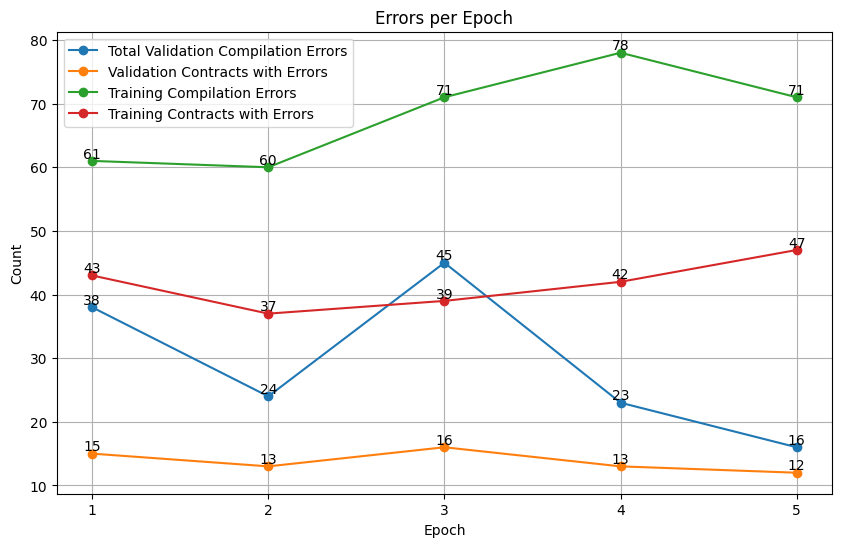

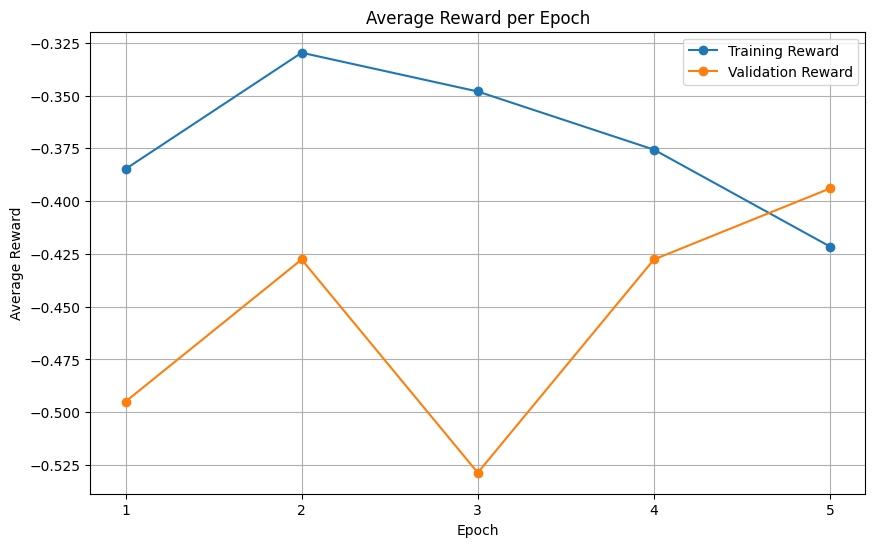

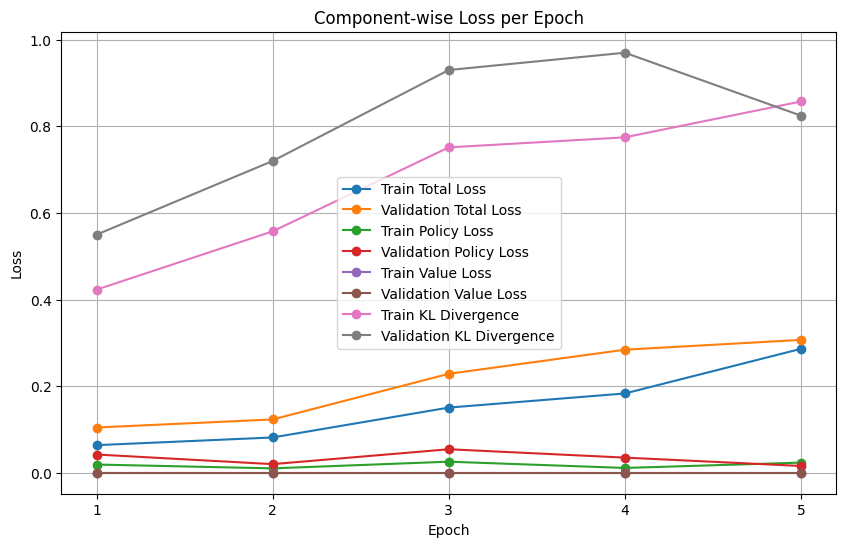

In [19]:
train(prompts,validation_prompts, loaded_checkpoint)